In [1]:
"""Data inspection."""

'Data inspection.'

In [2]:
import csv
import importlib
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os

import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import toylosses
importlib.reload(toylosses)
import vis
importlib.reload(vis)

CRYO_DIR = '/cryo/'

IMG_SHAPE = (128, 128)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)

TRAIN_VAL_DIR = os.path.join(CRYO_DIR, 'train_val_datasets')

TRAIN_DATASET_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_exp_%s.npy' % SHAPE_STR)
TRAIN_LABELS_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_exp_labels_%s.csv' % SHAPE_STR)

DATASET_PATH = os.path.join(TRAIN_VAL_DIR, 'val_cryo_exp_%s.npy' % SHAPE_STR)
DATASET = np.load(DATASET_PATH)

OUTPUT = '/scratch/users/nmiolane/output_cryo_exp'
CMAP = 'gray'
DEVICE = 'cuda'

Using numpy backend


ModuleNotFoundError: No module named 'geomstats.spd_matrices_space'

In [86]:
dataset = datasets.get_dataset_cryo_exp((128, 128))
train, val = datasets.split_dataset(dataset)
np.save(os.path.join(TRAIN_VAL_DIR, 'val_cryo_exp_128x128.npy'), val)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)


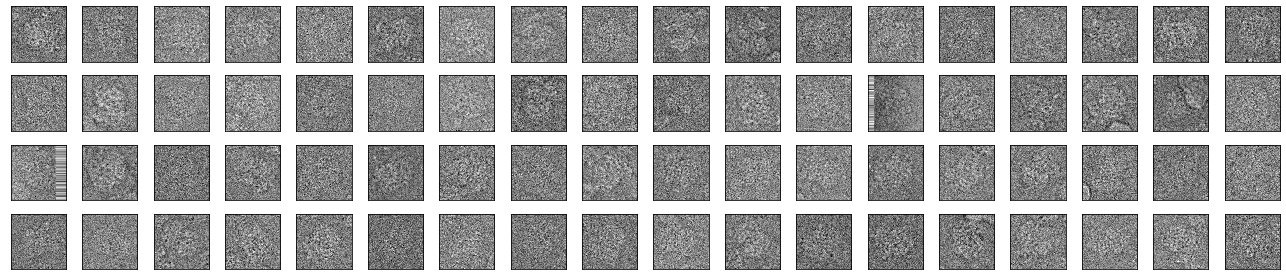

In [74]:
vis.show_data(TRAIN_DATASET_PATH)

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch

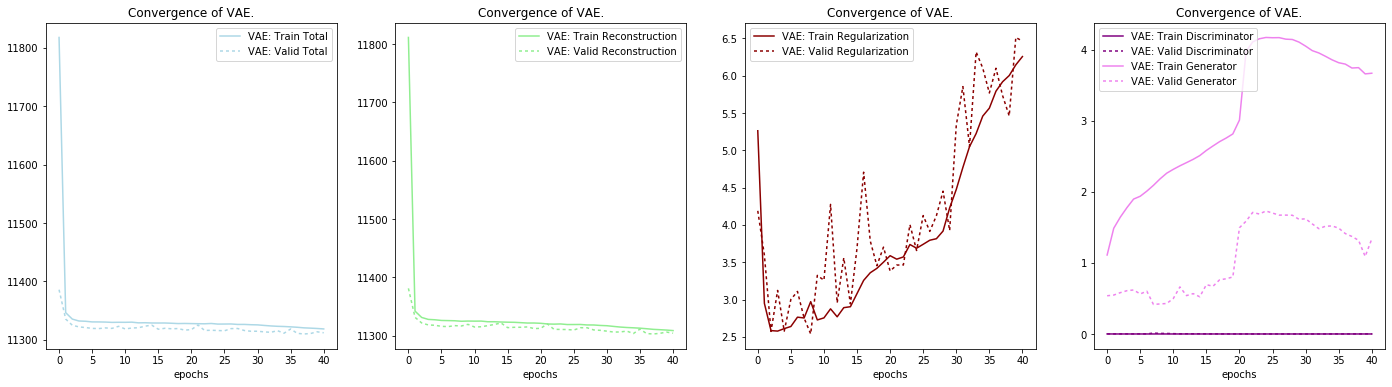

In [4]:
vis.plot_losses(OUTPUT)

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...


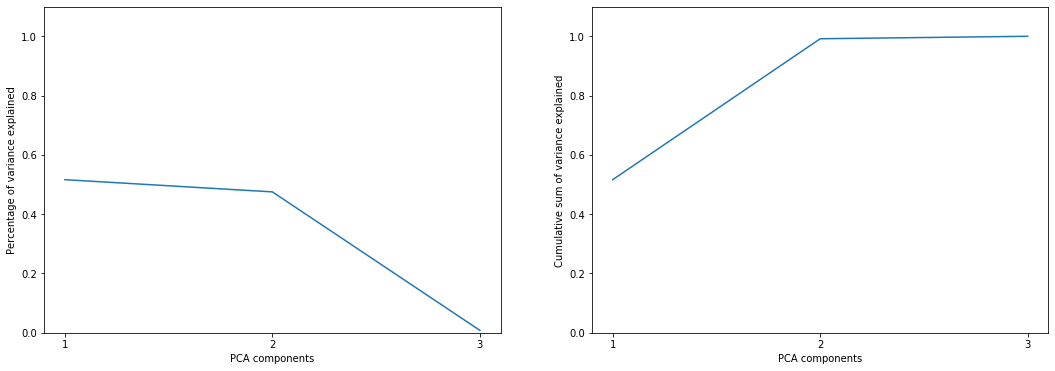

In [12]:
ax = vis.plot_variance_explained(OUTPUT, TRAIN_DATASET_PATH)

In [11]:
unexplained_var = vis.get_unexplained_variance(
            OUTPUT, dataset_path=TRAIN_DATASET_PATH, variance_name='eucl')
print(unexplained_var)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.


RuntimeError: CUDA out of memory. Tried to allocate 8.08 GiB (GPU 0; 7.93 GiB total capacity; 1.68 GiB already allocated; 737.19 MiB free; 35.27 MiB cached)

In [13]:
def get_cryo(dataset_path, labels_path=None, n_pca_components=2, epoch_id=None):
    labels = {}
    labels['focus'] = []
    labels['theta'] = []
    if labels_path is not None:
        with open(labels_path, 'r') as csv_file:
            reader = csv.reader(csv_file)
            for i_row, row in enumerate(reader):
                if i_row == 0:
                    continue
                labels['focus'].append(float(row[0]))
                labels['theta'].append(float(row[1]))
        
    # Note: the test dataset needs to be unshuffled here
    mus = analyze.latent_projection(output=OUTPUT, dataset_path=dataset_path, epoch_id=epoch_id)
    print(mus.shape)
    _, projected_mus = analyze.pca_projection(mus=mus, n_pca_components=n_pca_components)

    return projected_mus, labels

In [14]:
FOCUS_MAX = 2.
start = 0.5
by = 0.5
num = int((FOCUS_MAX - start) / by + 1)
colormap = cm.get_cmap('viridis')
COLORS_FOCUS = colormap(np.linspace(start=0, stop=1, num=num))

start = -180
by = 1
num = 2 * 180 + 1
colormap = cm.get_cmap('twilight')
COLORS_THETA = colormap(np.linspace(start=0, stop=1, num=num))

COLORS = {
    'focus': COLORS_FOCUS,
    'theta': COLORS_THETA
}

def plot_cryo(ax, img_path, labels_path, n_pc=2, label_name='focus', epoch_id=None):
    projected_mus, labels = get_cryo(img_path, labels_path, n_pca_components=n_pc, epoch_id=epoch_id)
    colored_labels = labels[label_name]
    if label_name == 'focus':
        colored_labels = [focus / 10000. for focus in colored_labels]

    for mu, colored_label in zip(projected_mus, colored_labels):
        #if label_name == 'theta' and focus != 2.5:
        #    continue
        if label_name == 'focus':##
            color_id = int(2 * colored_label) - 1
            if color_id > 3:
                color_id = 3
            
        elif label_name == 'theta':
            color_id = int((colored_label + 180))
            
        colors = COLORS[label_name]
        if n_pc == 2:
            im = ax.scatter(mu[0], mu[1], c=np.array([colors[color_id]]), s=4)
        else:
            im = ax.scatter(mu[0], mu[1], mu[2], c=np.array([colors[color_id]]))
    return im, ax

In [15]:
_, labels = get_cryo(TRAIN_DATASET_PATH, TRAIN_LABELS_PATH)

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
(8278, 3)


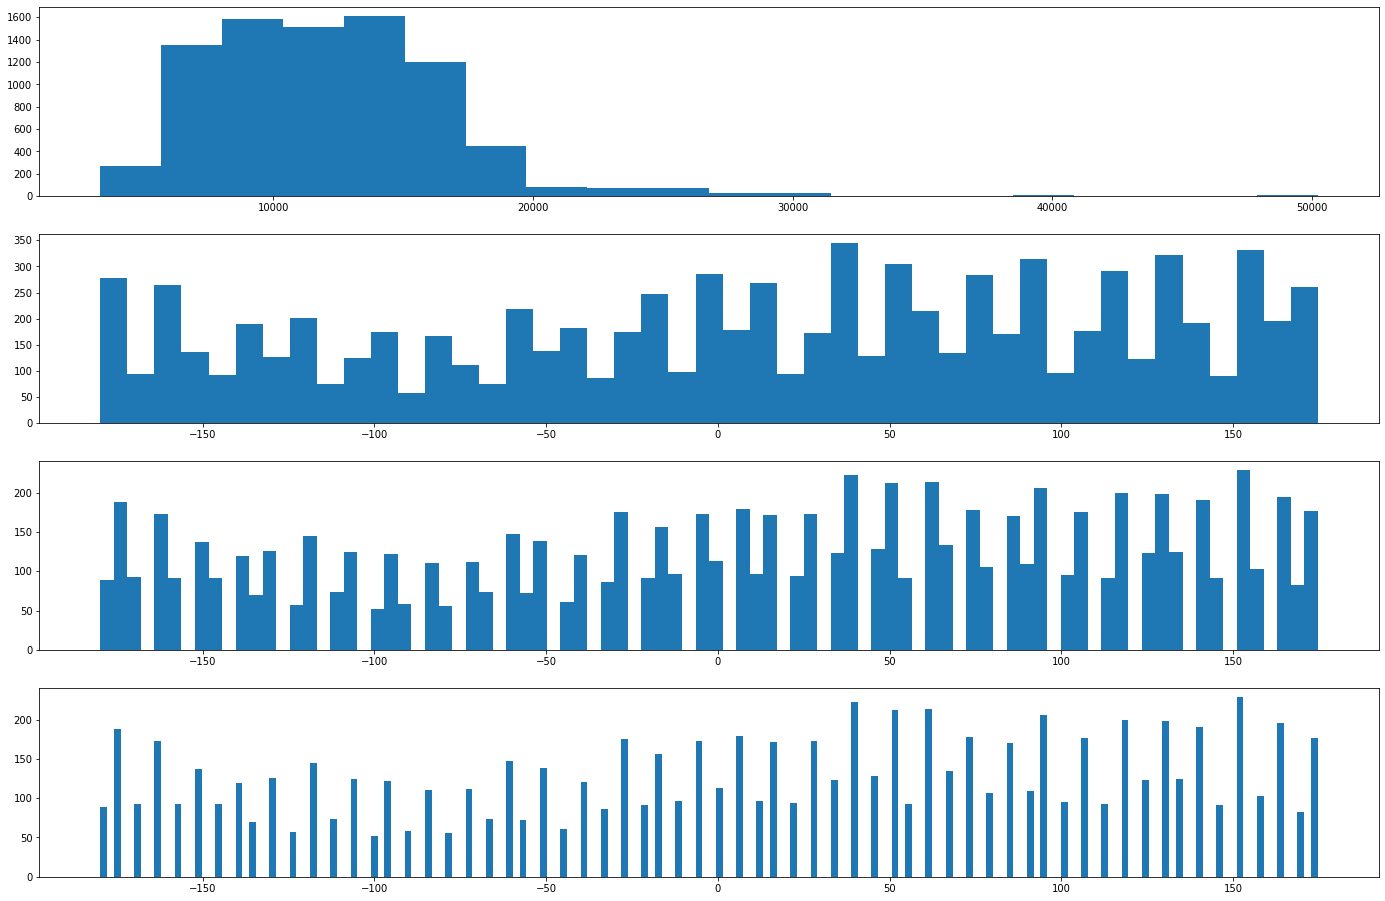

In [143]:
fig = plt.figure(figsize=(24, 16))

ax = fig.add_subplot(411)
ax = ax.hist(labels['focus'], bins=20)

ax = fig.add_subplot(412)
ax = ax.hist(labels['theta'], bins=45)

ax = fig.add_subplot(413)
ax = ax.hist(labels['theta'], bins=90)

ax = fig.add_subplot(414)
ax = ax.hist(labels['theta'], bins=180)

# 2D

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
(8278, 3)


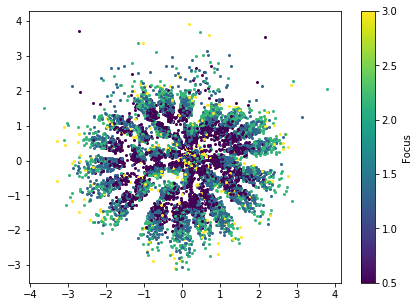

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

im, ax = plot_cryo(ax, TRAIN_DATASET_PATH, TRAIN_LABELS_PATH)
cb = fig.colorbar(im, ax=ax)
focus = cb.set_label('Focus')
yticklabels = cb.ax.set_yticklabels(np.arange(start=0.5, stop=5.5, step=0.5))

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
(8278, 3)


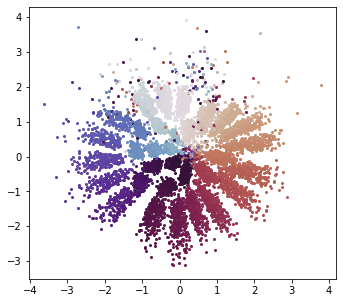

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 5))

im, ax = plot_cryo(ax, TRAIN_DATASET_PATH, TRAIN_LABELS_PATH, label_name='theta')

# 3D

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
(8278, 3)


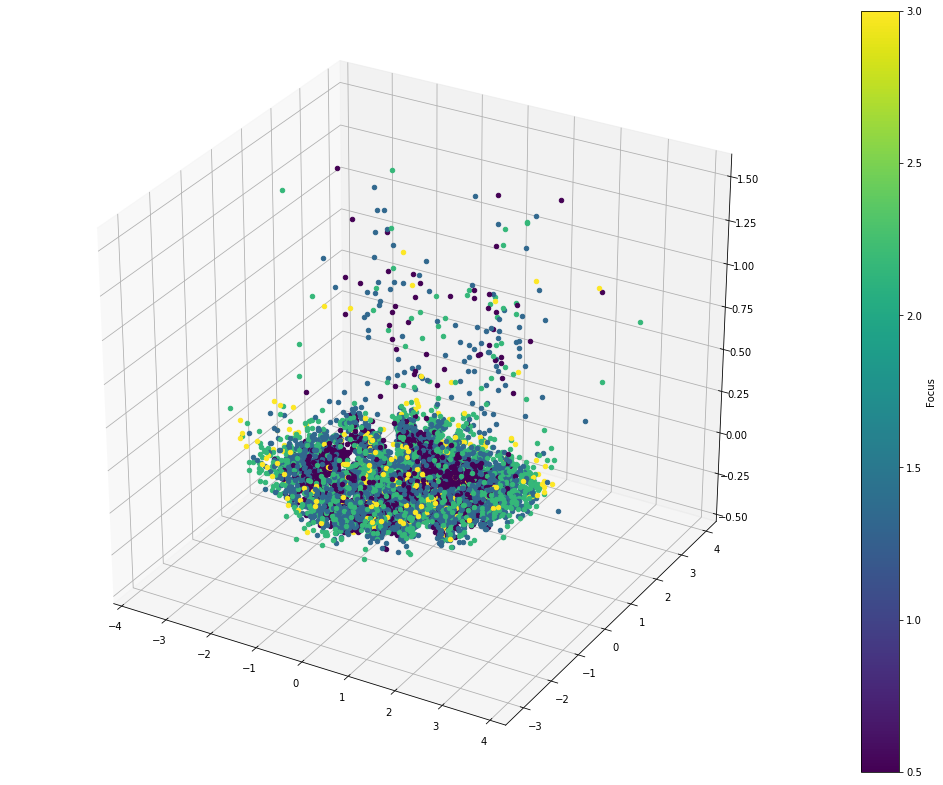

In [18]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')

im, ax = plot_cryo(ax, TRAIN_DATASET_PATH, TRAIN_LABELS_PATH, n_pc=3)
cb = fig.colorbar(im, ax=ax)
focus = cb.set_label('Focus')
yticklabels = cb.ax.set_yticklabels(np.arange(start=0.5, stop=3.5, step=0.5))

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_180_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
(8278, 3)


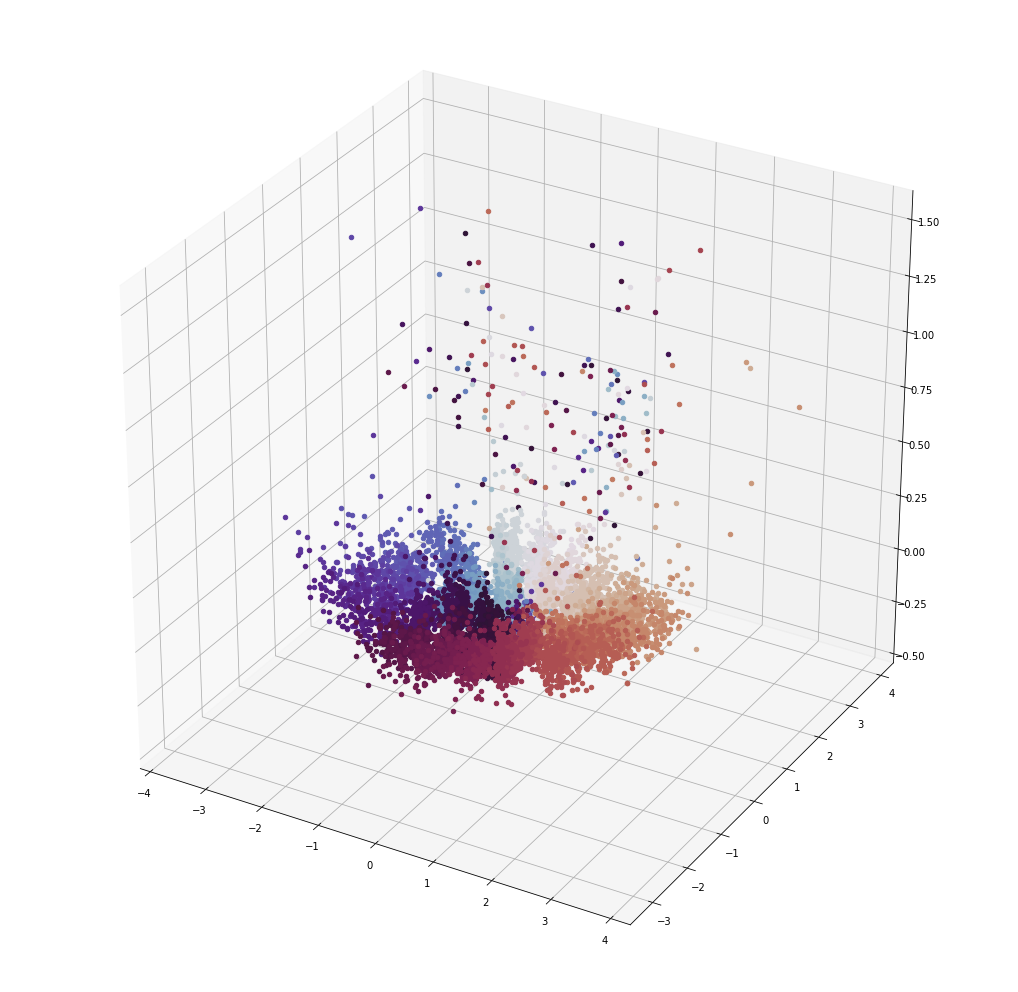

In [19]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

im, ax = plot_cryo(ax, TRAIN_DATASET_PATH, TRAIN_LABELS_PATH, n_pc=3, label_name='theta')

# Reconstructions

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_10_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_10_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_10_checkpoint.pth.


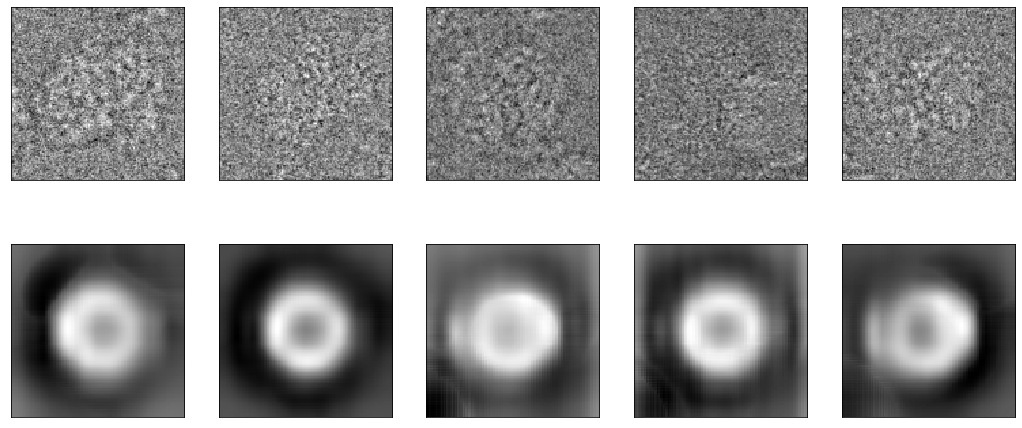

In [8]:
epoch_id = 10
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_DATASET_PATH, epoch_id=epoch_id, cmap=CMAP)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)
Loading encoder...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_20_checkpoint.pth.
Loading decoder...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_20_checkpoint.pth.


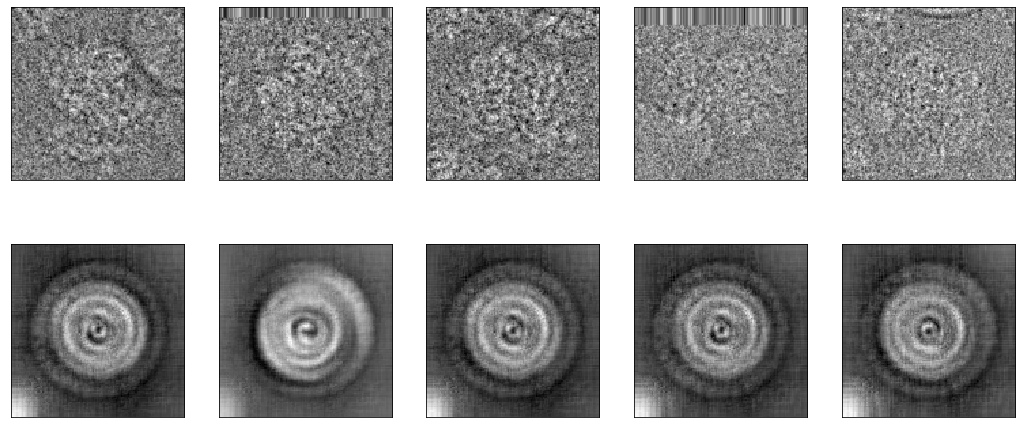

In [17]:
epoch_id = 20
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_DATASET_PATH, epoch_id=epoch_id, cmap=CMAP)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)
Loading encoder...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.
Loading decoder...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_40_checkpoint.pth.


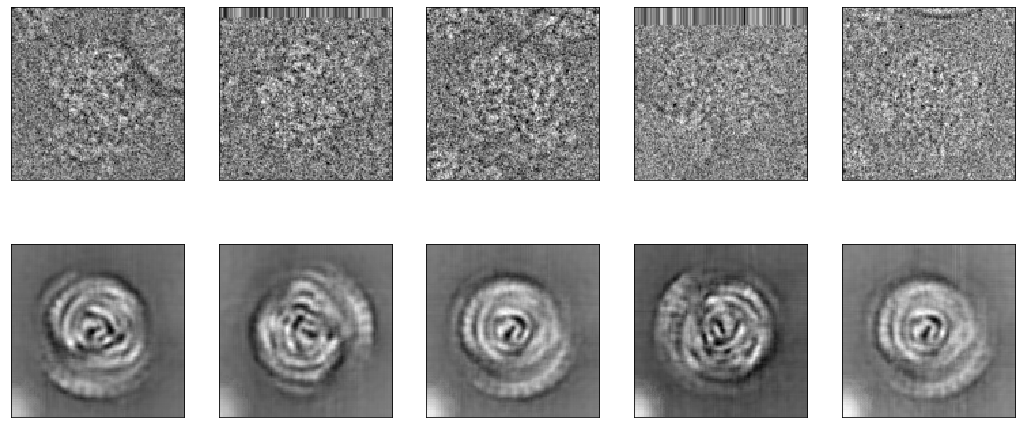

In [18]:
epoch_id = 40
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_DATASET_PATH, epoch_id=epoch_id, cmap=CMAP)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_60_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_60_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_60_checkpoint.pth.


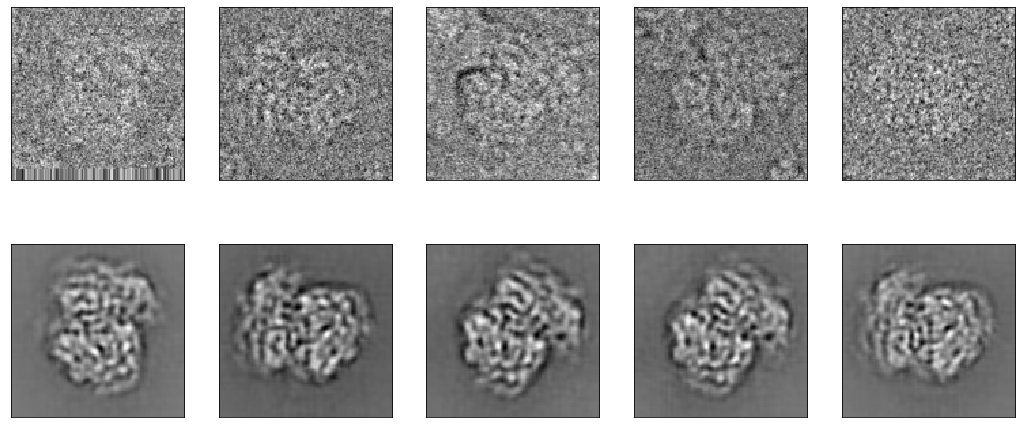

In [153]:
epoch_id = 60
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_DATASET_PATH, epoch_id=epoch_id, cmap=CMAP)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_245_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_245_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_exp/train_vae/epoch_245_checkpoint.pth.


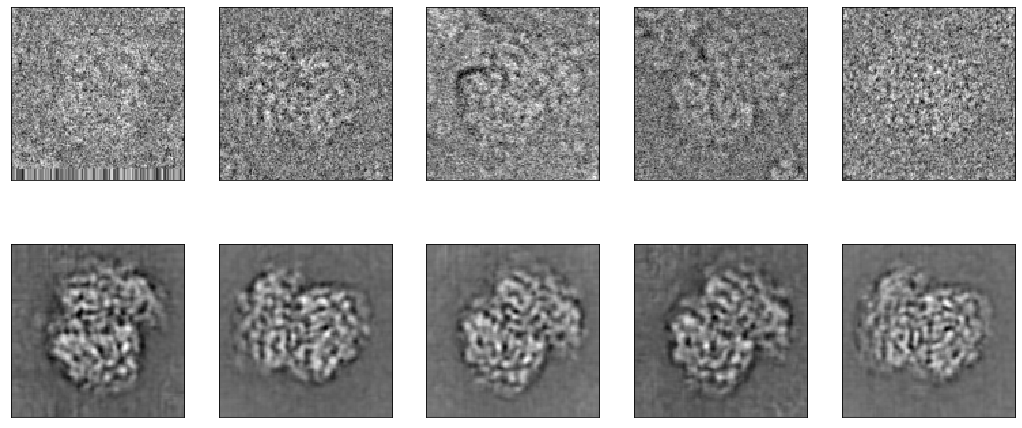

In [172]:
epoch_id = 245
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_DATASET_PATH, epoch_id=epoch_id, cmap=CMAP)

In [1]:
epoch_id = 180
print(TRAIN_DATASET_PATH)
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_DATASET_PATH, epoch_id=epoch_id, cmap=CMAP)

NameError: name 'TRAIN_DATASET_PATH' is not defined